# Goal
The goal of this project: Train a model that is as accurate as possible to predict the survival rates of passengers.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler
#from sklearn.svm import SVC

In [3]:
#import train and test datasets
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")

**Quick analysis:**

The training dataset includes information regarding:
-  passenger ID, 
-  survived: Survived (0 = No; 1 = Yes),
-  pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
-  name: Name
-  sex: Sex
-  age: Age
-  sibsp: Number of Siblings/Spouses Aboard
-  parch: Number of Parents/Children Aboard
-  ticket: Ticket Number
-  fare: Passenger Fare
-  cabin: Cabin
-  embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

I believe that Class, sex, age, siblings/spouse, cabin and where they embarked will affect the survival rates for these reasons:

-  class: better access to information and lifeboats,
-  sex: more females survived than males (bias),
-  age: as the younger you are the harder you will struggle to survive and also be placed on a lifeboat,
-  siblings/spouse: those that travel together would look after each other, and
-  cabin: perhaps the location affects access to lifeboats
-  embarkation: possible socio-economic reasons or length of trip depends what cabin is purchased?

I will see through Exploratory Data Analysis (EDA) whether my initial estimates hold any merit or if other correlations emerge.

In [4]:
train_data.columns = train_data.columns.str.lower()

# **Exploratory Analysis**

In [5]:
survived=train_data.groupby('survived').count()
survived

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


Text(0.5, 0, 'Survived (0 = Dead,1 = Survived)')

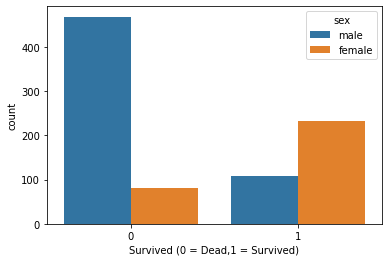

In [6]:
sns.countplot(data=train_data, x ='survived', hue = 'sex')
plt.xlabel('Survived (0 = Dead,1 = Survived)' )

Text(0.5, 0, 'Survived (0 = Dead,1 = Survived)')

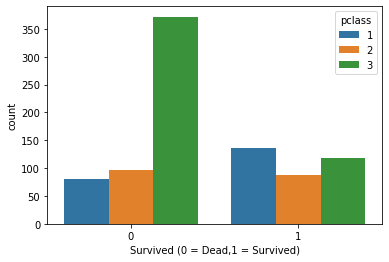

In [7]:
sns.countplot(x="survived",
              hue="pclass",
              data=train_data)
plt.xlabel('Survived (0 = Dead,1 = Survived)' )

In [8]:
train_data.corr()

,passengerid,survived,pclass,age,sibsp,parch,fare
passengerid,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
sibsp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


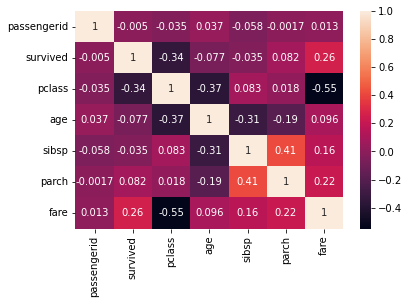

In [9]:
#This is a heatmap of the above information that makes it easier to see the features
#that correlate with each other (if any).
sns.heatmap(train_data.corr(), annot=True)
plt.show()

With the above heatmap, it is easy to see the features with the strongest positive correlations (orange) and the features with the strongest negative correlations (black).

We can conclude that there are strong positive correlations between SibSp and Parch—and that makes sense because children often have siblings, and parents and children often travel together. We can also see that Pclass and Fare are strongly negatively correlated—that makes sense because 1st class tickets are more expensive than lower class tickets, meaning as class goes down (closer to 1) the fare goes up. Finally Age and Pclass are moderately negatively correlated—since richer people are generally older.

In [10]:
#Sex was not included in the above correlation as it is a string.  
#We can use .get_dummies().  This converts a categorical variable into 
#dummy (binary) variables

train_data['sex'].str.get_dummies().corrwith(train_data['survived']/train_data['survived'].max())

female    0.543351
male     -0.543351
dtype: float64

This indicates that being male was strongly negatively correlated with the survival rate and the opposite for women.

<AxesSubplot:xlabel='familysize', ylabel='survived'>

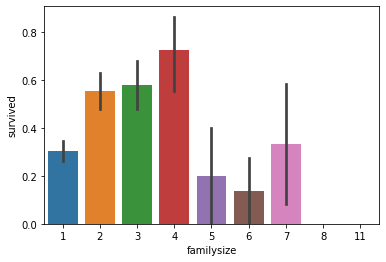

In [11]:
#Let's see if family size affects survival rates
train_data["familysize"] = train_data["sibsp"] + train_data["parch"] + 1

sns.barplot(x = "familysize", y ="survived", data = train_data)

<AxesSubplot:title={'center':'Survived by family size'}, xlabel='familysize'>

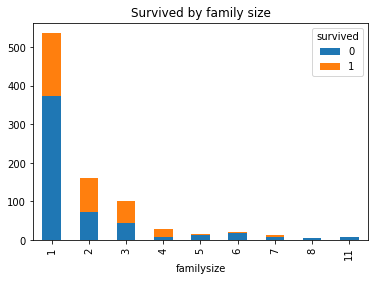

In [12]:
pd.crosstab(train_data['familysize'], train_data['survived']).plot(kind='bar', stacked=True, title="Survived by family size")

It appears that family sized did affect the survival rates at least up to a family size of 4. Then it appears negligable. I will use this in my analysis.

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
 12  familysize   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [14]:
# number of null values in dataset
train_data.isnull().sum() 

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
familysize       0
dtype: int64

We can see from the above listing that there is 177 missing values in age. I believe age is an important factor in survival because those that were able to fend for themselves (not elderly or a small child) would stand a better chance of surviving. I will try and find the mean age by sex and class to substitute the missing values.

There are too many missing values in the cabin column and I will exclude this column from my analysis.

There are 2 missing entries on embarked. I will see if it is easy to establish where they embarked. If not, I will exclude them from the analysis.

Text(0.5, 1.0, 'Missing values heatmap')

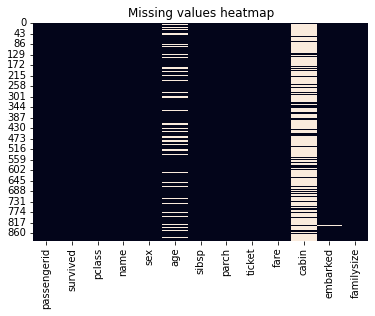

In [15]:
#another way of presenting the above missing data visually
sns.heatmap(train_data.isnull(), cbar = False).set_title("Missing values heatmap")

# Data Cleanup and Engineering

In [16]:
#Check for duplicated passenger info.  There isn't any to deal with.
duplications = train_data.duplicated().sum() 
duplications

0

In [17]:
#change the values in the 'fare' column to integers for ease of calculations
train_data['fare']=train_data['fare'].astype(int)

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    int64  
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
 12  familysize   891 non-null    int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 90.6+ KB


In [19]:
#Fill in missing Port of embarkation values as there are 2 missing
train_data['embarked'].value_counts()

S    644
C    168
Q     77
Name: embarked, dtype: int64

In [20]:
missing_embarked = train_data[pd.isnull(train_data.embarked)]
missing_embarked

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,familysize
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80,B28,NaN,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80,B28,NaN,1


In [21]:
#the missing info belong to 2 females, I will ascertain the mean fare by class for females only
female_only = train_data[train_data['sex'] == 'female'].groupby(["embarked","pclass"])["fare"].mean()
female_only

embarked  pclass
C         1         115.186047
          2          24.857143
          3          14.347826
Q         1          90.000000
          2          12.000000
          3           9.666667
S         1          98.583333
          2          21.746269
          3          18.147727
Name: fare, dtype: float64

The above data are the mean prices for females grouped by ports of embarkations. As both passengers with missing embarkation information paid 80 and are in first class, I will insert Q as their embarkation port as all other first class fares are well above the 80 that was paid.

In [22]:
train_data["embarked"] = train_data["embarked"].fillna("Q")

In [23]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    int64  
 10  cabin        204 non-null    object 
 11  embarked     891 non-null    object 
 12  familysize   891 non-null    int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 90.6+ KB


In [24]:
#Fill in missing age values
by_sex_class = train_data.groupby(['sex', 'pclass'])

In [25]:
def impute_median(series):
    return series.fillna(series.median())

In [26]:
train_data.age = by_sex_class['age'].transform(impute_median)

# Factorizing Features
I will factorise sex or make the words male/female be represented by numbers (male = 0, female = 1)


In [27]:
#I will factorise sex (male = 0, female = 1)
train_data['sex_f'] = pd.factorize(train_data['sex'])[0]

In [28]:
#I will factorise port of embarkation (S = 0, C = 1, Q = 2)
train_data['embarked_f'] = pd.factorize(train_data['embarked'])[0]
train_data[['embarked', 'embarked_f']]

,embarked,embarked_f
0,S,0
1,C,1
2,S,0
3,S,0
4,S,0
...,...,...
886,S,0
887,S,0
888,S,0
889,C,1


In [29]:
#drop the passengerid and cabin column as I feel they won't add much to the prediction.
train_data=train_data.drop(['passengerid','cabin'], axis=1)
train_data.head(2)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,familysize,sex_f,embarked_f
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7,S,2,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71,C,2,1,1


array([[<AxesSubplot:title={'center':'survived'}>,
        <AxesSubplot:title={'center':'pclass'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'sibsp'}>,
        <AxesSubplot:title={'center':'parch'}>,
        <AxesSubplot:title={'center':'fare'}>],
       [<AxesSubplot:title={'center':'familysize'}>,
        <AxesSubplot:title={'center':'sex_f'}>,
        <AxesSubplot:title={'center':'embarked_f'}>]], dtype=object)

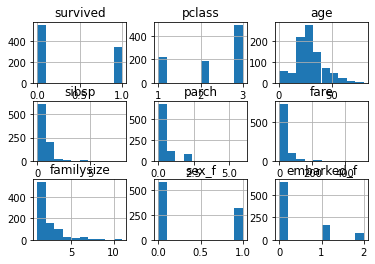

In [30]:
train_data.hist()

In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    int64  
 1   pclass      891 non-null    int64  
 2   name        891 non-null    object 
 3   sex         891 non-null    object 
 4   age         891 non-null    float64
 5   sibsp       891 non-null    int64  
 6   parch       891 non-null    int64  
 7   ticket      891 non-null    object 
 8   fare        891 non-null    int64  
 9   embarked    891 non-null    object 
 10  familysize  891 non-null    int64  
 11  sex_f       891 non-null    int64  
 12  embarked_f  891 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 90.6+ KB


My initial thoughts have been verified by the above analysis. I will use the following information to train/test the data for predicting the survival rate of passengers.

-  pclass (class),
-  sex_f (sex factorized),
-  age,
-  sibsp (siblings/spouse),
-  family size,
-  parch (parents of children on board)
-  fare
-  embarked_f (where they embarked)

# Modelling

I am using Supervised Machine Learning models as we know the answer of who survived and who died. Since we have a classification issue (yes or no, binary 0 or 1) we can use models such as: Logistic Regression, Random Forest Classification, Support Vector Machine (SVM), Naive Bayes, k-NN, or other deep learning models

I did a seperate analysis of the following models (see my GitHub portfolio for details, username: kbolon1):
-  Logistic Regression, 
-  Random Forest Classification, and 
-  Support Vector Machine 
and had the best results with the Random Forest Classification once I added family size to my analysis and have included the model below.

# Train the Model

In [32]:
#drop the column "survived" from file as we are creating a ML to predict
#y is true data (Y_true) the survivors from the original file, we will try and predict Y_new
X_train = train_data[['pclass','age', 'sibsp', 'parch', 'fare', 'familysize', 'sex_f', 'embarked_f']]
y_train = train_data["survived"]

In [33]:
X_train.shape, y_train.shape

((891, 8), (891,))

In [34]:
rfc = RandomForestClassifier(n_estimators=70, max_depth=4)    #Hyperparam: n_estimators(number of trees)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=70)

In [35]:
print(f'Train Score = {round(rfc.score(X_train, y_train), 2)}')

Train Score = 0.84


# Cross Validation on Random Forest Classifier

In [36]:
cross_accuracy_log = cross_val_score(rfc,  #estimator: the model that you want to evalueate
                                     X_train, # the training data
                                     y_train,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL=np.round_(cross_accuracy_log, 2)
CAL

array([0.77, 0.83, 0.84, 0.79, 0.84])

# Test Data

In [37]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [38]:
test_data.columns = test_data.columns.str.lower()

In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass       418 non-null    int64  
 2   name         418 non-null    object 
 3   sex          418 non-null    object 
 4   age          332 non-null    float64
 5   sibsp        418 non-null    int64  
 6   parch        418 non-null    int64  
 7   ticket       418 non-null    object 
 8   fare         417 non-null    float64
 9   cabin        91 non-null     object 
 10  embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [40]:
test_data.isna().sum()

passengerid      0
pclass           0
name             0
sex              0
age             86
sibsp            0
parch            0
ticket           0
fare             1
cabin          327
embarked         0
dtype: int64

In [41]:
test_data['fare'].fillna(0, inplace = True)

In [42]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass       418 non-null    int64  
 2   name         418 non-null    object 
 3   sex          418 non-null    object 
 4   age          332 non-null    float64
 5   sibsp        418 non-null    int64  
 6   parch        418 non-null    int64  
 7   ticket       418 non-null    object 
 8   fare         418 non-null    float64
 9   cabin        91 non-null     object 
 10  embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [43]:
test_data['fare']=test_data['fare'].astype(int)


In [44]:
#Fill in missing age values
by_sex_class_test = test_data.groupby(['sex', 'pclass'])

In [45]:
test_data.age = by_sex_class_test['age'].transform(impute_median)

I will not be using the feature 'cabin' and therefore not try to replace the missing values.  It will be removed from the analysis

In [46]:
#Let's see if family size affects survival rates
test_data["familysize"] = test_data["sibsp"] + test_data["parch"] + 1

In [47]:
#I will factorise sex (male = 0, female = 1)
test_data['sex_f'] = pd.factorize(test_data['sex'])[0]

In [48]:
#I will factorise port of embarkation (S = 0, C = 1, Q = 2)
test_data['embarked_f'] = pd.factorize(test_data['embarked'])[0]
test_data[['embarked', 'embarked_f']]

,embarked,embarked_f
0,Q,0
1,S,1
2,Q,0
3,S,1
4,S,1
...,...,...
413,S,1
414,C,2
415,S,1
416,S,1


In [49]:
test_data.isna().sum()

passengerid      0
pclass           0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             0
cabin          327
embarked         0
familysize       0
sex_f            0
embarked_f       0
dtype: int64

In [50]:
#y is true data (Y_true) the survivors from the original file, we will try and predict Y_new
X_test = test_data[['pclass','age', 'sibsp', 'parch', 'fare', 'familysize', 'sex_f', 'embarked_f']]

In [51]:
#predictions on real data
y_pred = rfc.predict(X_test)

In [52]:
output = pd.DataFrame({'PassengerId': test_data.passengerid, 'Survived': y_pred})
output.to_csv('submission_14_Oct_rfc.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
